### 🧼 Pipeline de Preprocesamiento del Dataset NuminaMath 1.5

Este pipeline se encarga de preparar el dataset original **NuminaMath 1.5** para su uso en tareas posteriores de clasificación y generación. A través de una serie de pasos cuidadosamente diseñados, se garantiza que los problemas seleccionados sean de alta calidad, estén correctamente anotados y estén redactados en inglés. El flujo completo incluye:

#### 1. **Carga del dataset**

El conjunto `NuminaMath-1.5` es cargado desde Hugging Face o desde disco, y se convierte a formato `DatasetDict` para facilitar su procesamiento estructurado.

#### 2. **Filtrado de ejemplos válidos**

Se eliminan aquellos problemas:

* Que son generados sintéticamente (`synthetic=True`).
* Que no fueron marcados como válidos por revisores humanos (`problem_is_valid != 'Yes'` o `solution_is_valid != 'Yes'`).

Esto se realiza mediante una función auxiliar `is_valid_example`.

#### 3. **Validación de campos esenciales**

Se descartan todos los ejemplos que presenten valores nulos o vacíos en los campos fundamentales:

* `problem`
* `solution`
* `answer`

Esto asegura que todos los problemas seleccionados sean completos y auto-contenidos.

#### 4. **Filtrado por idioma (detección de inglés)**

Se utiliza la biblioteca `langdetect` para asegurar que los problemas estén redactados en inglés, lo cual es imprescindible para los modelos de lenguaje utilizados en fases posteriores. Esta detección se realiza con la función `detectar_ingles`, y se marca cada ejemplo con una etiqueta `is_en`.

#### 5. **Guardado del subset procesado**

El subset final, conformado únicamente por problemas válidos y en inglés, se guarda en disco usando `save_to_disk`, lo que permite su reutilización eficiente en futuras etapas del proyecto.

#### 6. **Validación estructural y análisis exploratorio**

Una vez procesado, el dataset se recarga y se inspeccionan:

* Las columnas presentes y su formato (`dataset.features`).
* La distribución de etiquetas `problem_type` y `question_type`.
* La validez global de los campos `problem_is_valid` y `solution_is_valid`.

---

Este pipeline garantiza que el corpus final esté alineado con los requisitos del proyecto: calidad semántica, validez lógica y compatibilidad idiomática con los modelos LLM de destino.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!apt-get update
!apt-get install -y octave liboctave-dev
!pip install datasets huggingface_hub vllm math-verify openpyxl

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,740 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,246 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packa

In [ ]:
import sys
import os

# 1. Instalar dependencias solo si estamos en Colab
if "google.colab" in sys.modules:
    !pip install torch fsspec datasets optuna langdetect huggingface_hub vllm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.2/377.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 127.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
"""
Notebook optimizado para procesar el dataset NuminaMath 1.5.
Incluye:
- Instalación de dependencias (condicional para Colab)
- Carga del dataset original
- Filtrado y validación de problemas válidos y en inglés
- Guardado del subset procesado
- Revisión y análisis del contenido
"""

import sys
import os
from datasets import load_dataset, load_from_disk, DatasetDict
from langdetect import detect, DetectorFactory
from collections import Counter
import random

In [ ]:
# 2. Definir rutas para carga y guardado
dataset_path_raw = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5"
dataset_path_en = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_valid_en"

In [ ]:
# === 1. Cargar el dataset desde Hugging Face o desde disco local ===
# Este paso permite reutilizar el dataset descargado previamente.
# Si el archivo local no existe, se descarga desde Hugging Face y se guarda para futuras ejecuciones.

from datasets import load_dataset, load_from_disk
import os

# Ruta donde se guarda o se busca el dataset procesado en crudo
if not os.path.exists(dataset_path_raw):
    # Descargar desde Hugging Face si no está disponible localmente
    ds = load_dataset("AI-MO/NuminaMath-1.5")
    ds.save_to_disk(dataset_path_raw)  # Guardar localmente para uso posterior
else:
    # Cargar dataset previamente guardado desde disco
    ds = load_from_disk(dataset_path_raw)


README.md:   0%|          | 0.00/5.01k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/160M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/896215 [00:00<?, ? examples/s]

Saving the dataset (0/3 shards):   0%|          | 0/896215 [00:00<?, ? examples/s]

In [ ]:
# === 2. Filtrar problemas válidos y de origen humano ===
# Se eliminan los ejemplos generados sintéticamente o con problemas/soluciones no validadas.
# Esto garantiza la calidad del corpus antes de aplicar tareas de clasificación o generación.

def is_valid_example(example):
    """
    Determina si un ejemplo del dataset es válido según los siguientes criterios:
    - No fue generado de forma sintética (`synthetic` es False).
    - El problema fue validado como correcto (`problem_is_valid` == "Yes").
    - La solución fue validada como correcta (`solution_is_valid` == "Yes").

    Args:
        example (dict): Ejemplo del dataset con metadatos.

    Returns:
        bool: True si el ejemplo es válido, False en caso contrario.
    """
    return (
        example["synthetic"] is False and
        example["problem_is_valid"] == "Yes" and
        example["solution_is_valid"] == "Yes"
    )

# Aplicar el filtro al conjunto de entrenamiento del dataset original
ds_valid = ds["train"].filter(is_valid_example)


Filter:   0%|          | 0/896215 [00:00<?, ? examples/s]

In [ ]:
# === 3. Eliminar ejemplos con campos esenciales vacíos ===
# Se asegura que cada ejemplo tenga los campos `problem`, `solution` y `answer` completos.
# Esta limpieza es clave para evitar errores en etapas de entrenamiento o evaluación.

essential_fields = ["problem", "solution", "answer"]

# Filtrar ejemplos que contengan valores vacíos o nulos en alguno de los campos requeridos
ds_valid = ds_valid.filter(
    lambda x: all(x[k] not in [None, ""] for k in essential_fields)
)


Filter:   0%|          | 0/520811 [00:00<?, ? examples/s]

In [ ]:
# === 4. Filtrar problemas escritos en inglés ===
# Se utiliza la biblioteca `langdetect` para asegurarse de que el problema esté redactado en inglés.
# Esto es fundamental ya que los modelos BERT utilizados están entrenados sobre corpus en inglés.

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # Para garantizar resultados reproducibles en detección de idioma

def detectar_ingles(row):
    """
    Detecta si el campo 'problem' de un ejemplo está escrito en inglés.

    Args:
        row (dict): Ejemplo con al menos el campo 'problem'.

    Returns:
        bool: True si el texto está en inglés, False si está en otro idioma o es inválido.
    """
    texto = row["problem"]
    if not texto or len(texto) < 5:
        return False  # Ignorar textos demasiado cortos o vacíos
    try:
        return detect(texto) == "en"
    except:
        return False  # Si hay error en la detección, lo descartamos

# Agrega una columna 'is_en' que indica si el problema está en inglés
ds_valid = ds_valid.map(lambda x: {"is_en": detectar_ingles(x)})

# Filtra únicamente los ejemplos cuyo problema esté en inglés
ds_valid_en = ds_valid.filter(lambda x: x["is_en"])


Map:   0%|          | 0/467891 [00:00<?, ? examples/s]

Filter:   0%|          | 0/467891 [00:00<?, ? examples/s]

In [ ]:
# === 5. Guardar el dataset final en inglés ===
# Esta etapa asegura la persistencia del corpus procesado para su reutilización en otras fases del proyecto.
# También incluye una verificación de seguridad para evitar guardar un dataset vacío.

# Verificar que el dataset no esté vacío después del filtrado por idioma
if len(ds_valid_en) == 0:
    raise ValueError("Dataset filtrado en inglés está vacío.")  # Previene errores silenciosos

# Guardar el dataset procesado en inglés en disco
ds_valid_en.save_to_disk(dataset_path_en)


Saving the dataset (0/2 shards):   0%|          | 0/452306 [00:00<?, ? examples/s]

In [ ]:
# === 6. Cargar el dataset procesado y realizar validaciones estructurales ===
# Esta etapa permite inspeccionar las características del corpus final, incluyendo:
# - Tipos de campos presentes.
# - Distribución de etiquetas de clasificación.
# - Estado de validación de problemas y soluciones.

from datasets import load_from_disk
from collections import Counter

# Cargar desde la ruta donde se guardó el dataset filtrado en inglés
dataset = load_from_disk(dataset_path_en)

# Mostrar las características de las columnas del dataset
print("Características del dataset:")
print(dataset.features)

# Ver la distribución de clases para el tipo de problema
print("\nDistribución de problem_type:")
print(Counter(dataset["problem_type"]))

# Ver la distribución de clases para el tipo de pregunta
print("\nDistribución de question_type:")
print(Counter(dataset["question_type"]))

# Validación de los campos de consistencia manual
print("\nValidación de campos:")
print(Counter(dataset["problem_is_valid"]))
print(Counter(dataset["solution_is_valid"]))


Características del dataset:
{'problem': Value(dtype='string', id=None), 'solution': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'problem_type': Value(dtype='string', id=None), 'question_type': Value(dtype='string', id=None), 'problem_is_valid': Value(dtype='string', id=None), 'solution_is_valid': Value(dtype='string', id=None), 'source': Value(dtype='string', id=None), 'synthetic': Value(dtype='bool', id=None), 'is_en': Value(dtype='bool', id=None)}

Distribución de problem_type:
Counter({'Algebra': 195534, 'Geometry': 107749, 'Number Theory': 43154, 'Combinatorics': 39844, 'Inequalities': 25941, 'Calculus': 21491, 'Logic and Puzzles': 14676, 'Other': 3917})

Distribución de question_type:
Counter({'math-word-problem': 255907, 'MCQ': 126434, 'proof': 69604, 'other': 361})

Validación de campos:
Counter({'Yes': 452306})
Counter({'Yes': 452306})


In [ ]:
# === 7. Visualización manual de ejemplos aleatorios del dataset ===
# Esta sección permite inspeccionar manualmente algunos problemas, soluciones y respuestas
# para validar la calidad semántica y la coherencia general del corpus procesado.

import random

# Seleccionar 5 índices aleatorios del dataset
samples = random.sample(range(len(dataset)), 5)

# Mostrar los campos principales de cada ejemplo
for i in samples:
    print(f"\n📘 Problem:\n{dataset[i]['problem']}")
    print(f"\n🧮 Solution:\n{dataset[i]['solution']}")
    print(f"\n✅ Answer:\n{dataset[i]['answer']}")
    print("-" * 60)



Problem:
Given propositions $p$ and $q$: Proposition $p$ states that the equation $4x^{2}-4(m-2)x+1=0$ has two unequal negative roots; Proposition $q$ states that the equation $x^{2}+3mx+1=0$ has no real roots. If $p \vee q$ is true and $\neg q$ is true, the range of values of the real number $m$ is _____.

Solution:
For proposition $p$ to be true, i.e., the equation $4x^{2}-4(m-2)x+1=0$ has two unequal negative roots, the following conditions must be satisfied:
$$
\begin{cases}
\Delta = 16(m-2)^{2} - 16 > 0 \\
m - 2 < 0
\end{cases}
$$
Solving these inequalities yields $m < 1$.

For proposition $q$ to be true, i.e., the equation $x^{2}+3mx+1=0$ has no real roots, we have:
$$
\Delta = 9m^2 - 4 < 0
$$
Solving this inequality yields $-\frac{2}{3} < m < \frac{2}{3}$.

Given that $p \vee q$ is true and $\neg q$ is true, we have $p$ is true and $q$ is false. Thus, $m \leq -\frac{2}{3}$ or $\frac{2}{3} \leq m < 1$.

Therefore, the answer is $m \leq -\frac{2}{3}$ or $\boxed{\frac{2}{3} \leq m

In [ ]:
# === 8. Detección de entradas con valores faltantes ===
# Como paso final de validación, se revisa si aún quedan ejemplos con
# campos vacíos o nulos en alguna de las columnas del dataset.

# Filtrar ejemplos que tengan al menos un campo vacío o nulo
missing = dataset.filter(lambda x: any(v is None or v == "" for v in x.values()))

# Reportar cuántos ejemplos presentan valores faltantes
print(f"\nNúmero de filas con valores faltantes: {len(missing)}")


Filter:   0%|          | 0/452306 [00:00<?, ? examples/s]


Número de filas con valores faltantes: 0


### 🔍 Clasificación Heurística de Resolubilidad por Código

Con el objetivo de enriquecer el corpus previamente filtrado, se incorpora una **etiqueta binaria `is_octave_resolvable`** que indica si un problema puede, en principio, resolverse mediante la generación de código computacional en **GNU Octave**. Esta etiqueta se obtiene a partir de una **heurística basada en reglas simbólicas**, la cual clasifica cada problema en función de su tipo y la naturaleza de la pregunta.

La estrategia se fundamenta en las siguientes observaciones:

* Los problemas cuya pregunta requiere una **demostración formal** (`question_type = "proof"`) suelen involucrar razonamientos abstractos no computacionales, por lo que se marcan como **no resolubles por código**.
* Las categorías `Logic and Puzzles` y `Other` contienen ejercicios cuya resolución frecuentemente depende de intuiciones humanas, acertijos o contextos no algebraizables, por lo que también se excluyen.
* Todos los demás problemas se consideran, por defecto, **resolubles mediante código en Octave**, especialmente aquellos que implican cálculo simbólico, numérico o algebraico.

La clasificación se implementa mediante una función `heuristic_resolvability` que se aplica al conjunto completo utilizando `map`, lo cual garantiza consistencia y eficiencia. Finalmente, el dataset enriquecido es almacenado en disco para futuras etapas del pipeline (clasificación automática, generación de código o evaluación).

Este enfoque permite una **segmentación temprana del corpus** entre problemas que requieren razonamiento simbólico abstracto y aquellos que son abordables por vía programática, optimizando así la asignación de estrategias de prompting y modelos de lenguaje específicos.




In [ ]:
from datasets import load_from_disk

# === 9. Cargar dataset previamente filtrado en inglés ===
# Se reutiliza el dataset limpio y validado para añadir una nueva etiqueta de resolubilidad.
dataset_path_en = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_valid_en"
dataset = load_from_disk(dataset_path_en)

# === 10. Heurística para clasificar si un problema es resoluble mediante código en Octave ===
def heuristic_resolvability(example):
    """
    Asigna una etiqueta booleana 'is_octave_resolvable' según reglas heurísticas simples:

    - Se consideran no resolubles:
        • Problemas cuya pregunta es del tipo 'proof'.
        • Problemas cuya categoría es 'Logic and Puzzles' o 'Other'.
    - Todo lo demás se considera potencialmente resoluble por código.

    Args:
        example (dict): Ejemplo del dataset.

    Returns:
        dict: Diccionario con la nueva clave 'is_octave_resolvable'.
    """
    if example["question_type"] == "proof":
        return {"is_octave_resolvable": False}
    if example["problem_type"] in ["Logic and Puzzles", "Other"]:
        return {"is_octave_resolvable": False}
    return {"is_octave_resolvable": True}

# Aplicar la heurística al dataset completo
dataset = dataset.map(heuristic_resolvability)

# Guardar el dataset con la nueva columna añadida
dataset.save_to_disk("/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_with_resolvability")

print("Clasificación heurística aplicada. Dataset guardado con columna 'is_octave_resolvable'.")



Saving the dataset (0/2 shards):   0%|          | 0/452306 [00:00<?, ? examples/s]

Clasificación heurística aplicada. Dataset guardado con columna 'is_octave_resolvable'.


### 🤖 Refinamiento de la Clasificación de Resolubilidad mediante Zero-Shot Learning

Si bien una primera etiqueta de resolubilidad computacional (`is_octave_resolvable`) fue asignada utilizando una heurística simbólica basada en el tipo de pregunta y de problema, este enfoque puede resultar insuficiente para capturar la complejidad semántica de ciertos enunciados. Por ello, se introdujo una segunda etapa de refinamiento basada en aprendizaje automático.

En particular, se utilizó un enfoque de **clasificación zero-shot**, que permite evaluar si un problema es resoluble mediante programación sin necesidad de entrenamiento adicional. Esta técnica se basa en el modelo **`facebook/bart-large-mnli`**, preentrenado sobre tareas de inferencia textual y adaptado para clasificación sin supervisión específica.

El procedimiento consistió en lo siguiente:

1. **Selección inicial**: Se seleccionaron únicamente los ejemplos previamente marcados como resolubles por la heurística (`is_octave_resolvable = True`).
2. **Formulación de etiquetas**: Se definieron dos clases candidatas:

   * `"solvable by programming"`
   * `"not solvable by programming"`
3. **Clasificación por lotes**: Se aplicó el modelo sobre los enunciados de los problemas en lotes de 32 ejemplos, utilizando la función `pipeline` de Hugging Face.
4. **Actualización condicional**: Si la predicción principal del modelo fue `"not solvable by programming"`, se sobrescribió el campo `is_octave_resolvable` del ejemplo correspondiente a `False`.

Esta etapa permite **refinar automáticamente la clasificación heurística**, basándose en la semántica del enunciado y no únicamente en etiquetas formales. Así, se logra una segmentación más precisa del corpus entre problemas abordables y no abordables mediante generación de código computacional.


In [ ]:
from datasets import load_from_disk, Dataset
from transformers import pipeline
from tqdm import tqdm
import torch

# === 1. Cargar el dataset previamente filtrado y validado ===
dataset_path_en = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_valid_en"
dataset = load_from_disk(dataset_path_en)

# === 2. Aplicar una heurística inicial simple de resolubilidad ===
# Se filtran como "no resolubles" los problemas tipo 'proof' o de categorías no computacionales.
def heuristic_resolvability(example):
    if example["question_type"] == "proof":
        return {"is_octave_resolvable": False}
    if example["problem_type"] in ["Logic and Puzzles", "Other"]:
        return {"is_octave_resolvable": False}
    return {"is_octave_resolvable": True}

dataset = dataset.map(heuristic_resolvability)

# === 3. Refinar la clasificación aplicando un modelo zero-shot ===
print("\n🔍 Refinando con zero-shot classification...\n")

# Cargar el modelo preentrenado BART para clasificación zero-shot
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0 if torch.cuda.is_available() else -1
)

# Definir las clases candidatas para inferencia
labels = ["solvable by programming", "not solvable by programming"]

# Identificar índices de los ejemplos marcados como resolubles por heurística
indices_to_check = [i for i, ex in enumerate(dataset) if ex["is_octave_resolvable"]]

# Evaluar por lotes usando clasificación zero-shot
batch_size = 32
for i in tqdm(range(0, len(indices_to_check), batch_size), desc="Zero-Shot Filtering"):
    batch_indices = indices_to_check[i:i + batch_size]
    batch_questions = [dataset[j]["problem"] for j in batch_indices]

    # Aplicar modelo a cada lote
    results = classifier(batch_questions, labels)

    # Actualizar campo 'is_octave_resolvable' según predicción principal
    for j, result in enumerate(results):
        top_label = result["labels"][0]
        if top_label == "not solvable by programming":
            dataset[batch_indices[j]]["is_octave_resolvable"] = False

# === 4. Guardar el dataset final refinado con clasificaciones actualizadas ===
final_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_with_resolvability"
dataset.save_to_disk(final_path)

print(f"\n✅ Proceso completo. Dataset refinado guardado en: {final_path}")



/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)



🔍 Refinando con zero-shot classification...



config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Zero-Shot Filtering: 100%|██████████| 11408/11408 [4:13:10<00:00,  1.33s/it]


Saving the dataset (0/2 shards):   0%|          | 0/452306 [00:00<?, ? examples/s]


✅ Proceso completo. Dataset refinado guardado en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_with_resolvability


### 📊 Estadísticas Finales de Resolubilidad Computacional

Una vez completado el proceso de clasificación —primero heurístico y luego refinado mediante zero-shot learning—, se procedió a cuantificar la distribución final de los problemas en función de su resolubilidad mediante código GNU Octave.

El siguiente bloque de código recupera el dataset anotado, computa la frecuencia de cada clase (`True` o `False` en el campo `is_octave_resolvable`) y presenta los resultados en una tabla resumen:

Este análisis cuantitativo permite dimensionar el subconjunto del corpus que puede ser efectivamente abordado mediante estrategias de generación de código. Dicha información resulta esencial para establecer los límites de aplicación del sistema propuesto y para diseñar estrategias adaptativas de prompting que consideren la naturaleza resoluble o no resoluble de cada problema.



In [ ]:
from datasets import load_from_disk
from collections import Counter
import pandas as pd

# === 1. Cargar el dataset anotado con resolubilidad ===
dataset_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_with_resolvability"
dataset = load_from_disk(dataset_path)

# === 2. Contar cuántos ejemplos fueron marcados como resolubles o no ===
stats = Counter(dataset["is_octave_resolvable"])

# === 3. Construir un resumen tabular con pandas ===
df_stats = pd.DataFrame([{
    "Total de problemas": len(dataset),
    "Problemas resolubles con código Octave": stats[True],
    "Problemas NO resolubles con código Octave": stats[False],
    "Porcentaje resolubles (%)": round(100 * stats[True] / len(dataset), 2)
}])

# === 4. Mostrar la tabla ===
print(df_stats)


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


   Total de problemas  Problemas resolubles con código Octave  \
0              452306                                  365044   

   Problemas NO resolubles con código Octave  Porcentaje resolubles (%)  
0                                      87262                      80.71  


### 🔁 Homogeneización del Formato del Corpus

Como etapa final del procesamiento del dataset **NuminaMath 1.5**, se realiza una transformación estructural para adaptarlo a un formato estandarizado, utilizado de forma uniforme en las siguientes fases del proyecto (entrenamiento, generación de código, validación, evaluación, etc.).

Esta homogeneización facilita la compatibilidad entre distintos datasets y modelos, y permite aplicar técnicas genéricas de prompting sobre campos consistentes. Se renombraron los campos principales y se consolidó la información relevante en una estructura fija:

* `question`: contiene el enunciado del problema (originalmente `problem`)
* `rationale`: solución paso a paso (originalmente `solution`)
* `answer`: respuesta final
* `problem_type`: categoría matemática
* `question_type`: tipo de pregunta
* `is_octave_resolvable`: etiqueta booleana que indica si el problema puede resolverse mediante código en GNU Octave


Este formato homogéneo se adopta como estándar para el resto del proyecto, permitiendo desarrollar flujos unificados para inferencia, generación, clasificación y evaluación con independencia del dataset original.



In [ ]:
from datasets import load_from_disk, Dataset
import os

def homogenize_numinamath(dataset):
    """
    Transforma el dataset NuminaMath-1.5 al formato estandarizado.

    Campos de salida:
    - question: enunciado del problema
    - rationale: solución paso a paso
    - answer: respuesta final
    - problem_type: tipo de problema matemático
    - question_type: tipo de pregunta
    - is_octave_resolvable: heurística de resolubilidad en GNU Octave
    """
    def transform(example):
        return {
            "question": example["problem"],
            "rationale": example.get("solution", ""),
            "answer": example.get("answer", "").strip(),
            "problem_type": example.get("problem_type"),
            "question_type": example.get("question_type"),
            "is_octave_resolvable": example.get("is_octave_resolvable", False),
        }

    # Aplicar la transformación y eliminar columnas anteriores
    return dataset.map(transform, remove_columns=dataset.column_names)

# === Rutas de entrada y salida ===
input_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_with_resolvability"
output_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_homogenized"

# Cargar dataset con resolubilidad
dataset = load_from_disk(input_path)

# Aplicar homogeneización de campos
homogenized_dataset = homogenize_numinamath(dataset)

# Guardar el nuevo dataset estructurado
homogenized_dataset.save_to_disk(output_path)
print(f"Dataset homogenizado guardado en: {output_path}")

# === Muestra de verificación manual ===
for i in range(3):
    print(f"\nPregunta:\n{homogenized_dataset[i]['question']}")
    print(f"\nSolución:\n{homogenized_dataset[i]['rationale']}")
    print(f"\nRespuesta:\n{homogenized_dataset[i]['answer']}")
    print(f"Tipo: {homogenized_dataset[i]['problem_type']} | Pregunta: {homogenized_dataset[i]['question_type']}")
    print(f"Resuelve en Octave: {homogenized_dataset[i]['is_octave_resolvable']}")



/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Saving the dataset (0/2 shards):   0%|          | 0/452306 [00:00<?, ? examples/s]

Dataset homogenizado guardado en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_homogenized

Pregunta:

Problem 1. Find all prime numbers $p$ for which there exist positive integers $x, y$ and $z$ such that the number

$$
x^{p}+y^{p}+z^{p}-x-y-z
$$

is a product of exactly three distinct prime numbers.


Solución:

Solution. Let $A=x^{p}+y^{p}+z^{p}-x-y-z$. For $p=2$, we take $x=y=4$ and $z=3$. Then $A=30=2 \cdot 3 \cdot 5$. For $p=3$ we can take $x=3$ and $y=2$ and $z=1$. Then again $A=30=2 \cdot 3 \cdot 5$. For $p=5$ we can take $x=2$ and $y=1$ and $z=1$. Again $A=30=2 \cdot 3 \cdot 5$.

Assume now that $p \geqslant 7$. Working modulo 2 and modulo 3 we see that $A$ is divisible by both 2 and 3. Moreover, by Fermat's Little Theorem, we have

$$
x^{p}+y^{p}+z^{p}-x-y-z \equiv x+y+z-x-y-z=0 \bmod p \text {. }
$$

Therefore, by the given condition, we have to solve the equation

$$
x^{p}+y^{p}+z^{p}-x-y-z=6 p
$$

If one of the numbers $x, y$ and $z$ is bigger than or equal to 2 , 

In [ ]:
from datasets import load_from_disk
import random
from collections import Counter

# === Análisis estructural y exploratorio del dataset homogenizado ===
# Este bloque permite inspeccionar la estructura del corpus estandarizado NuminaMath-1.5,
# incluyendo columnas, tipos de datos, distribución de etiquetas y ejemplos representativos.

# ─── 1. Cargar el dataset homogenizado desde disco ─────────────────────
dataset_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_homogenized"
dataset = load_from_disk(dataset_path)

# ─── 2. Mostrar estructura general del dataset ─────────────────────────
print("📦 Estructura del dataset homogenizado:")
print(f"Número de ejemplos: {len(dataset)}")

# Listado de columnas disponibles en cada ejemplo
print("\nColumnas disponibles:")
print(dataset.column_names)

# Tipos de datos asociados a cada columna
print("\nTipos de datos por columna:")
print(dataset.features)

# ─── 3. Mostrar distribución de etiquetas categóricas ─────────────────
print("\nDistribución por tipo de problema:")
print(Counter(dataset["problem_type"]))

print("\nDistribución por tipo de pregunta:")
print(Counter(dataset["question_type"]))

print("\nDistribución de resolubilidad en Octave:")
print(Counter(dataset["is_octave_resolvable"]))

# ─── 4. Mostrar un ejemplo aleatorio ───────────────────────────────────
print("\n🔍 Ejemplo aleatorio del dataset:")

# Selección aleatoria de un ejemplo del corpus
sample = random.choice(dataset)

# Mostrar campos principales del ejemplo
print(f"\nPregunta:\n{sample['question']}")
print(f"\nSolución:\n{sample['rationale']}")
print(f"\nRespuesta:\n{sample['answer']}")
print(f"Tipo: {sample['problem_type']} | Pregunta: {sample['question_type']}")
print(f"¿Resuelve en Octave? {sample['is_octave_resolvable']}")


📦 Estructura del dataset homogenizado:
Número de ejemplos: 452306

Columnas disponibles:
['answer', 'problem_type', 'question_type', 'is_octave_resolvable', 'question', 'rationale']

Tipos de datos por columna:
{'answer': Value(dtype='string', id=None), 'problem_type': Value(dtype='string', id=None), 'question_type': Value(dtype='string', id=None), 'is_octave_resolvable': Value(dtype='bool', id=None), 'question': Value(dtype='string', id=None), 'rationale': Value(dtype='string', id=None)}

Distribución por tipo de problema:
Counter({'Algebra': 195534, 'Geometry': 107749, 'Number Theory': 43154, 'Combinatorics': 39844, 'Inequalities': 25941, 'Calculus': 21491, 'Logic and Puzzles': 14676, 'Other': 3917})

Distribución por tipo de pregunta:
Counter({'math-word-problem': 255907, 'MCQ': 126434, 'proof': 69604, 'other': 361})

Distribución de resolubilidad en Octave:
Counter({True: 365044, False: 87262})

🔍 Ejemplo aleatorio del dataset:

Pregunta:
The graph of the function $f(x) = 2^x + 2^{

In [ ]:
from datasets import load_from_disk
import pandas as pd
import os

# === Exportar dataset homogenizado a formato CSV ===
# Este paso permite trabajar con el corpus en herramientas externas (Excel, Google Sheets, análisis en Pandas, etc.)

# ─── 1. Ruta donde está almacenado el dataset en formato Hugging Face ─────────────
dataset_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_homogenized"

# ─── 2. Cargar el dataset completo desde disco ────────────────────────────────────
dataset = load_from_disk(dataset_path)

# ─── 3. Convertir el dataset a DataFrame de Pandas ────────────────────────────────
# Esto facilita análisis exploratorios y exportación a otros formatos
df = dataset.to_pandas()

# ─── 4. Guardar el DataFrame como archivo CSV ─────────────────────────────────────
csv_path = os.path.join(dataset_path, "NuminaMath-1.5_homogenized.csv")
df.to_csv(csv_path, index=False)

print(f"✅ CSV guardado en: {csv_path}")



✅ CSV guardado en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_homogenized/NuminaMath-1.5_homogenized.csv


### 🧩 Extensión del Dataset para Evaluación Mediante Código Octave

Con el objetivo de instrumentar un sistema automatizado capaz de **generar, ejecutar y validar código en GNU Octave**, fue necesario extender el dataset homogenizado original mediante la incorporación de campos adicionales. Esta operación no altera los datos semánticos del corpus, sino que añade una serie de columnas que permitirán capturar todo el ciclo de inferencia y verificación automática asociado a cada problema.

En particular, se agregaron los siguientes campos:

* `raw_llm_output`: contiene la respuesta completa generada por el modelo LLM, incluyendo razonamientos, explicaciones y código.
* `octave_code`: representa el fragmento específico de código Octave extraído o generado para resolver el problema.
* `execution_output`: almacena la salida generada tras ejecutar el código en un entorno controlado.
* `execution_error`: captura cualquier error de ejecución (por ejemplo, errores de sintaxis o fallos en tiempo de ejecución).
* `is_valid_code`: etiqueta booleana que indica si el código se ejecutó correctamente sin errores.
* `is_correct`: etiqueta booleana que indica si la salida del código coincide con la respuesta esperada (`answer`).
* `parsed_answer`: valor numérico extraído automáticamente de la salida del código para comparación directa con `answer`.
* `explanation`: explicación textual generada por el modelo respecto al código Octave utilizado.

Esta extensión estructural convierte al dataset en un **contenedor dinámico**, preparado para registrar múltiples iteraciones de razonamiento computacional sobre cada problema. Además, facilita el diseño de métricas específicas de evaluación automática y permite almacenar el resultado de procesos como re-ejecuciones, validaciones simbólicas, y explicaciones generadas.

En resumen, esta etapa permite pasar de un corpus estático de problemas matemáticos a una estructura **interactiva y auditable**, adecuada para experimentos de prompting orientados a programación y validación algorítmica.


In [ ]:
from datasets import load_from_disk, Dataset
import os
import pandas as pd

# === Enriquecimiento del dataset con campos para evaluación por código ===
# Esta etapa agrega columnas vacías al dataset homogenizado, necesarias para almacenar:
# - Salidas generadas por LLMs
# - Código Octave
# - Resultados de ejecución
# - Evaluaciones de validez y corrección
# - Explicaciones generadas

# ─── 1. Rutas de entrada y salida ───────────────────────────────────────
original_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_homogenized"
output_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_with_octave"

# ─── 2. Cargar el dataset homogenizado original ─────────────────────────
dataset = load_from_disk(original_path)

# ─── 3. Definir nuevas columnas a incorporar ─────────────────────────────
# Cada columna se inicializa con un valor por defecto
additional_columns = {
    "raw_llm_output": None,         # Respuesta bruta generada por el modelo LLM
    "octave_code": None,            # Código GNU Octave generado
    "execution_output": None,       # Resultado de ejecutar el código
    "execution_error": None,        # Mensaje de error (si lo hubo)
    "is_valid_code": False,         # Bandera booleana: ¿el código se ejecuta sin errores?
    "is_correct": False,            # Bandera booleana: ¿la salida coincide con la respuesta?
    "parsed_answer": None,          # Valor numérico extraído de la salida del código
    "explanation": None,            # Explicación textual generada del código
}

# ─── 4. Función que añade los campos vacíos a cada ejemplo ──────────────
def add_empty_fields(example):
    """
    Añade al ejemplo todos los campos definidos en `additional_columns`
    con su valor por defecto correspondiente.
    """
    for key, default_value in additional_columns.items():
        example[key] = default_value
    return example

# Aplicar la transformación sobre todo el dataset
dataset_augmented = dataset.map(add_empty_fields)

# ─── 5. Guardar el nuevo dataset en disco ───────────────────────────────
os.makedirs(output_path, exist_ok=True)
dataset_augmented.save_to_disk(output_path)

# También se exporta a CSV para facilitar visualización externa
df = dataset_augmented.to_pandas()
csv_path = os.path.join(output_path, "NuminaMath-1.5_with_octave_code.csv")
df.to_csv(csv_path, index=False)

print(f"✅ CSV guardado en: {csv_path}")



Map:   0%|          | 0/452306 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/452306 [00:00<?, ? examples/s]

✅ CSV guardado en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_with_octave/NuminaMath-1.5_with_octave_code.csv


### 🧠 Selección de Corpus Diverso para Recuperación RAG

En el contexto de estrategias de prompting con **Recuperación Aumentada por Generación (RAG)**, resulta esencial disponer de un subconjunto representativo y diverso de problemas resolubles. Esto permite enriquecer el contexto de entrada del modelo LLM sin comprometer la eficiencia computacional durante la recuperación.

Para lograrlo, se implementó una técnica de reducción basada en **clustering semántico**, cuyo objetivo es seleccionar un subconjunto balanceado de problemas con alta variabilidad lingüística y temática. El proceso se describe a continuación:

1. **Generación de Embeddings**:
   Se utilizó el modelo `all-MiniLM-L6-v2` de la biblioteca **Sentence Transformers**, que codifica cada enunciado (`question`) en un vector denso de 384 dimensiones. Este embedding captura la semántica subyacente del texto y sirve como base para el agrupamiento.

2. **Agrupamiento con cuML (GPU)**:
   Para garantizar escalabilidad, se utilizó **cuML KMeans** sobre GPU, que permite realizar clustering eficiente sobre grandes cantidades de vectores. Se definió un número objetivo de **30,000 clústeres**, correspondiente al número de ejemplos que se deseaba retener.

3. **Selección de Representantes**:
   Para cada clúster, se identificó el punto más cercano al centroide mediante la métrica de distancia euclidiana (`cdist`). De este modo, se selecciona el ejemplo más representativo de cada grupo semántico, maximizando la diversidad interna del corpus resultante.

4. **Construcción del corpus RAG**:
   Los ejemplos seleccionados se reconstruyeron como un nuevo dataset, agregando además sus embeddings precomputados como campo auxiliar. Este corpus constituye la **base documental comprimida** sobre la que se aplicarán algoritmos de recuperación semántica en etapas posteriores del pipeline.

Este procedimiento permite construir un **corpus optimizado para recuperación**, manteniendo la diversidad conceptual y temática del conjunto original, y reduciendo significativamente el tamaño sin sacrificar cobertura.



In [ ]:
from datasets import load_from_disk, Dataset
import os
from pathlib import Path
from sentence_transformers import SentenceTransformer
import numpy as np
import cupy as cp
from cuml.cluster import KMeans as cuKMeans
from scipy.spatial.distance import cdist
import torch
from tqdm import tqdm

# === Generación de corpus diverso reducido para RAG mediante clustering semántico ===

# ─────────────────────────────────────────────────────────────────────────────
# Paso 1: Cargar dataset filtrado con problemas resolubles en Octave
resolvable_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_resolvable_only"
resolvable_dataset = load_from_disk(resolvable_path)

# ─────────────────────────────────────────────────────────────────────────────
# Paso 2: Generar embeddings con Sentence Transformers
# Usamos 'all-MiniLM-L6-v2', un modelo eficiente y rápido para codificación semántica
print("\n🔍 Generando embeddings con SentenceTransformer...")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# Extraer solo los enunciados de los problemas
questions = resolvable_dataset["question"]

# Generar embeddings por lotes con soporte para progreso y GPU
embeddings = model.encode(
    questions,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

# ─────────────────────────────────────────────────────────────────────────────
# Paso 3: Clustering en GPU con cuML KMeans para seleccionar problemas diversos
target_size = 30000  # Tamaño objetivo del corpus final
print(f"\n🎯 Seleccionando {target_size} ejemplos diversos con cuML KMeans (GPU)...")

# Convertir embeddings a cupy (formato requerido por cuML)
embeddings_cp = cp.asarray(embeddings)

# Ejecutar KMeans en GPU con cuML
kmeans = cuKMeans(n_clusters=target_size, max_iter=100, random_state=42)
kmeans.fit(embeddings_cp)

# ─────────────────────────────────────────────────────────────────────────────
# Paso 4: Seleccionar ejemplo más cercano al centroide de cada clúster

# Convertir centroides a NumPy para cálculos posteriores
centroids = cp.asnumpy(kmeans.cluster_centers_)
embeddings_np = np.asarray(embeddings)

# Para cada centroide, encontrar el índice del ejemplo más cercano
closest_indices = np.argmin(cdist(centroids, embeddings_np), axis=1)

# ─────────────────────────────────────────────────────────────────────────────
# Paso 5: Construir el corpus reducido a partir de los índices seleccionados

# Recuperar ejemplos originales y añadir su embedding
selected_examples = [resolvable_dataset[int(i)] for i in closest_indices]
selected_embeddings = embeddings_np[closest_indices]

for idx, emb in enumerate(selected_embeddings):
    selected_examples[idx]["embedding"] = emb.tolist()  # Guardar embedding como lista JSON

# Crear un nuevo dataset Hugging Face con los ejemplos seleccionados
selected_dataset = Dataset.from_list(selected_examples)

# ─────────────────────────────────────────────────────────────────────────────
# Paso 6: Guardar el corpus reducido para uso posterior en recuperación (RAG)
corpus_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus"
os.makedirs(corpus_path, exist_ok=True)
selected_dataset.save_to_disk(corpus_path)

print(f"\n✅ Corpus RAG reducido guardado en: {corpus_path}")



🔍 Generando embeddings con SentenceTransformer...


Batches:   0%|          | 0/5704 [00:00<?, ?it/s]


🎯 Seleccionando 30000 ejemplos diversos con cuML KMeans (GPU)...


🧠 Buscando vecinos más cercanos: 100%|██████████| 30000/30000 [14:03<00:00, 35.56it/s]


Saving the dataset (0/1 shards):   0%|          | 0/30000 [00:00<?, ? examples/s]


✅ Corpus RAG reducido guardado en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus


,Total de ejemplos,Columnas,Tipos de datos,Dimensión de embeddings,Norma media de embeddings,Longitud promedio de preguntas,Desviación estándar de longitud,Distribución por tipo de problema,Distribución por tipo de pregunta
0,30000,"[answer, problem_type, question_type, is_octave_resolvable, question, rationale, embedding]","{'answer': Value(dtype='string', id=None), 'problem_type': Value(dtype='string', id=None), 'question_type': Value(dtype='string', id=None), 'is_octave_resolvable': Value(dtype='bool', id=None), 'question': Value(dtype='string', id=None), 'rationale': Value(dtype='string', id=None), 'embedding': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}",384,1.0,45.1823,33.081688,"{'Calculus': 1688, 'Number Theory': 3152, 'Algebra': 14577, 'Inequalities': 1219, 'Geometry': 5946, 'Combinatorics': 3418}","{'math-word-problem': 20036, 'MCQ': 9955, 'other': 9}"


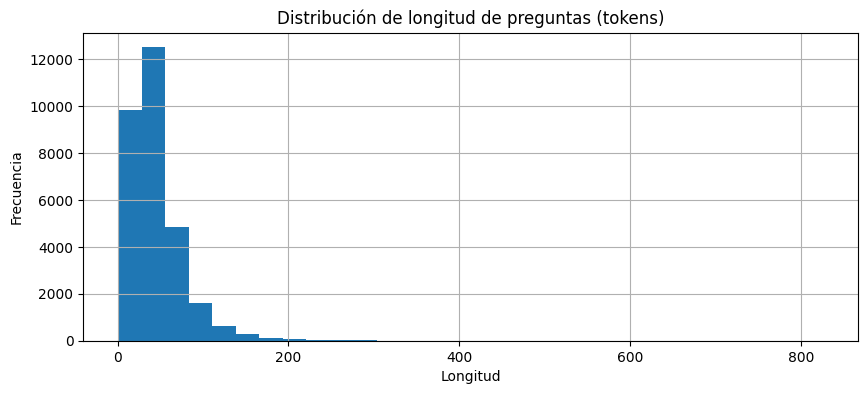

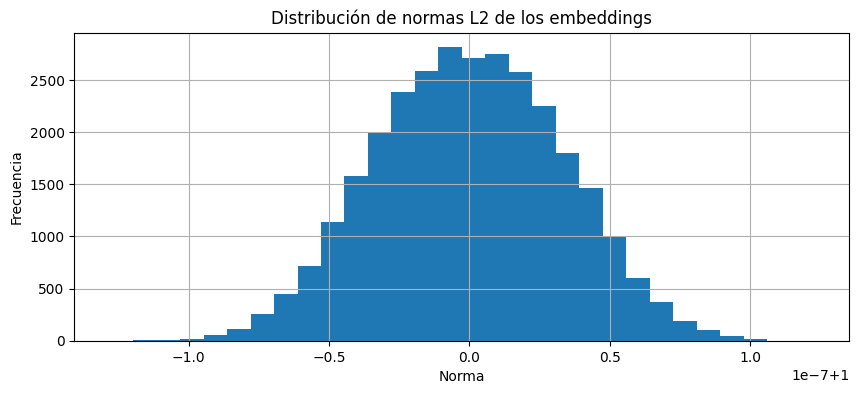

In [ ]:
# ─── Requiere instalación previa ───
# Ejecuta esto si estás en un entorno nuevo o Colab
#!pip install -q datasets matplotlib

# ─── Imports ───
from datasets import load_from_disk
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── Cargar dataset ───
rag_corpus_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus"
rag_dataset = load_from_disk(rag_corpus_path)

# ─── Análisis general ───
num_examples = len(rag_dataset)
columns = rag_dataset.column_names
types = rag_dataset.features

# Distribución por tipo de problema y pregunta
problem_type_dist = Counter(rag_dataset["problem_type"])
question_type_dist = Counter(rag_dataset["question_type"])

# Longitud promedio de las preguntas
question_lengths = [len(q.split()) for q in rag_dataset["question"]]
mean_len = np.mean(question_lengths)
std_len = np.std(question_lengths)

# Embedding: dimensión y norma
embedding_matrix = np.array(rag_dataset["embedding"])
embedding_dim = embedding_matrix.shape[1] if embedding_matrix.ndim == 2 else "Invalid"
embedding_norms = np.linalg.norm(embedding_matrix, axis=1) if embedding_matrix.ndim == 2 else []

# ─── Mostrar resumen ───
summary = {
    "Total de ejemplos": num_examples,
    "Columnas": columns,
    "Tipos de datos": types,
    "Dimensión de embeddings": embedding_dim,
    "Norma media de embeddings": np.mean(embedding_norms) if len(embedding_norms) else "N/A",
    "Longitud promedio de preguntas": mean_len,
    "Desviación estándar de longitud": std_len,
    "Distribución por tipo de problema": dict(problem_type_dist),
    "Distribución por tipo de pregunta": dict(question_type_dist),
}

# Mostrar resumen en tabla
pd.set_option("display.max_colwidth", None)
display(pd.DataFrame([summary]))

# ─── Gráficos ───
plt.figure(figsize=(10, 4))
plt.hist(question_lengths, bins=30)
plt.title("Distribución de longitud de preguntas (tokens)")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

if len(embedding_norms):
    plt.figure(figsize=(10, 4))
    plt.hist(embedding_norms, bins=30)
    plt.title("Distribución de normas L2 de los embeddings")
    plt.xlabel("Norma")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()


In [ ]:
import time
import logging
from huggingface_hub import snapshot_download
from vllm import LLM, SamplingParams

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger(__name__)

class VLLMGenerator:
    def __init__(
        self,
        model_name: str,
        download: bool = False,
        temperature: float = 0.0,
        top_p: float = 1.0,
        max_tokens: int = 1024,
    ):
        """
        Initializes the VLLM model and sampling parameters.
        Optionally downloads the model locally into a folder named after the model.

        :param model_name: Hugging Face model identifier for vLLM (e.g., 'org/model').
        :param download: If True, downloads the model to a local directory derived from model_name.
        :param temperature: Sampling temperature for generation (0.0 for deterministic).
        :param top_p: Nucleus sampling probability (1.0 uses all tokens).
        :param max_tokens: Maximum number of tokens to generate.

        """

        # Determine model source: HF cache or local folder
        self.model_source = model_name
        if download:
            folder_name = model_name.split('/')[-1]
            logger.info("Downloading model %s to ./%s...", model_name, folder_name)
            self.model_source = snapshot_download(
                repo_id=model_name,
                local_dir=folder_name
            )
            logger.info("Model downloaded to: %s", self.model_source)

        # Load the model (detects GPU/CPU automatically), force generate task
        load_start = time.time()
        self.llm = LLM(
            model=self.model_source,
            trust_remote_code=True,
            task="generate"
        )
        logger.info("Model loaded in %.2f seconds", time.time() - load_start)


        # Configure sampling parameters optimized for code
        self.sampling_params = SamplingParams(
            temperature=temperature,
            top_p=top_p,
            max_tokens=max_tokens
        )
        logger.info("Sampling parameters set: %s", self.sampling_params)

    def generate(self, prompts: list) -> list:
        """
        Generates text for a list of prompts using the vLLM model.

        :param prompts: List of prompt strings to generate responses for.
        :return: List of generation outputs (strings).
        """
        start = time.time()
        outputs = self.llm.generate(prompts, self.sampling_params)
        logger.info("Generation completed in %.2f seconds", time.time() - start)
        # Extract and return text responses
        return [out.outputs[0].text for out in outputs]

INFO 06-05 16:50:09 [__init__.py:243] Automatically detected platform cuda.


In [ ]:
import subprocess
import tempfile
import os
import shutil

class OctaveExecutionError(Exception): pass
class OctaveTimeoutError(Exception): pass

class OctaveCodeExecutor:
    def __init__(self, timeout: int = 10, octave_cmd: str = 'octave', max_output_size: int = 10000):
        self.timeout = timeout
        self.octave_cmd = octave_cmd
        self.max_output_size = max_output_size

        # ✅ Verificar que el binario esté disponible
        if shutil.which(self.octave_cmd) is None:
            raise FileNotFoundError(
                f"❌ El binario '{self.octave_cmd}' no se encontró en el sistema.\n"
                f"🛠 Asegúrate de instalar Octave con:\n"
                f"!apt-get update && apt-get install -y octave"
            )

    def _write_temp_file(self, code: str) -> str:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.m', delete=False) as f:
            f.write(code)
            return f.name

    def execute_with_timeout(self, code: str) -> tuple[str | None, str | None]:
        file_path = self._write_temp_file(code)
        try:
            result = subprocess.run(
                [self.octave_cmd, "--quiet", "--no-gui", "--eval", f"run('{file_path}')"],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                timeout=self.timeout,
                text=True,
                check=False
            )
            stdout = result.stdout[:self.max_output_size].strip()
            stderr = result.stderr.strip()
            return stdout, stderr if stderr else None
        except subprocess.TimeoutExpired:
            raise OctaveTimeoutError("⏱️ Tiempo de ejecución excedido para el código Octave.")
        finally:
            os.remove(file_path)


### 🧠 Generación de Código Octave para Construcción de un Corpus Robusto

Una de las metas fundamentales de este trabajo es la creación de un **corpus matemático versátil y validado**, compuesto por problemas matemáticos acompañados de su respectivo código ejecutable en GNU Octave. Este corpus no solo contiene las soluciones en lenguaje natural, sino también representaciones computables verificadas automáticamente, lo cual lo convierte en un recurso especialmente valioso para el entrenamiento de modelos de generación de código, sistemas de resolución simbólica y entornos educativos computacionales.

#### 1. Proceso de Generación del Código

A partir de una versión curada del dataset NuminaMath-1.5 (resoluble según heurísticas y filtrado zero-shot), se genera código Octave de manera automática utilizando un modelo LLM. El proceso está orientado a la productividad y precisión: para cada problema se construye un *prompt* que guía al modelo a producir exclusivamente código funcional, sin explicaciones o anotaciones.

#### 2. Extracción Estructurada del Código

Dado que la salida del modelo puede contener formato adicional (por ejemplo, bloques de Markdown), se aplica un preprocesamiento que aísla de forma segura el contenido del código usando expresiones regulares. Este paso garantiza que el código almacenado sea directamente ejecutable en entornos GNU Octave o compatibles como MATLAB.

#### 3. Validación Automática por Ejecución

Una característica distintiva del pipeline es la **validación automatizada de cada código generado**. Se ejecuta el código Octave y se analiza su salida en comparación con la respuesta esperada del dataset. Se consideran correctos los resultados que coinciden numéricamente o contienen subconjuntos relevantes de los valores esperados, permitiendo una validación flexible y escalable.

Esta etapa permite distinguir entre:

* Códigos correctamente ejecutados y válidos (`is_correct = True`)
* Códigos con errores de ejecución
* Códigos que se ejecutan pero no generan la respuesta esperada

#### 4. Revisión Manual Selectiva

Para los casos donde el código se ejecuta correctamente pero no coincide exactamente con la respuesta, se habilita una revisión humana asistida mediante consola. Esta revisión permite validar manualmente resultados que, aunque no coincidan numéricamente de forma exacta, reflejan una solución correcta al problema planteado.

#### 5. Consolidación y Exportación del Corpus

Una vez ejecutado el proceso en bloques, los resultados se consolidan y se construye un **corpus final** con los registros marcados como correctos. Este corpus incluye:

* Problema matemático en lenguaje natural
* Solución en lenguaje natural (`rationale`)
* Código Octave funcional
* Resultado de la ejecución
* Etiquetas semánticas (tipo de problema, tipo de pregunta)
* Indicador de corrección

Este enfoque garantiza un corpus de alta calidad, **autovalidado** y directamente útil para tareas de entrenamiento, evaluación de modelos, recuperación aumentada (RAG), y pruebas de razonamiento simbólico y computacional.



In [ ]:
from datasets import load_from_disk, Dataset
import random
import os
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
import numpy as np
import torch
from tqdm import tqdm
import re
from math_verify import parse, verify


In [ ]:
from datasets import load_from_disk
import os

# === Inicialización de CSV para anotación de resultados de generación y ejecución ===
# Este script prepara un archivo CSV editable a partir del corpus reducido para RAG,
# añadiendo columnas auxiliares para almacenar salidas de modelos LLM, código Octave generado,
# resultados de ejecución, errores, y verificación de corrección.

# ─── 1. Ruta al dataset homogenizado y reducido para RAG ─────────────────────────────
corpus_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus"
dataset = load_from_disk(corpus_path)

# ─── 2. Convertir el dataset a un DataFrame de Pandas ───────────────────────────────
df = dataset.to_pandas()

# ─── 3. Añadir columnas vacías para completar en etapas posteriores ─────────────────
# Estas columnas se rellenarán con resultados generados durante la evaluación
df["raw_llm_output"] = ""       # Respuesta completa generada por el modelo
df["octave_code"] = ""          # Código Octave extraído o generado
df["execution_result"] = ""     # Resultado de ejecutar el código
df["execution_error"] = ""      # Mensaje de error, si ocurre
df["is_correct"] = ""           # Bandera de corrección (True/False/pendiente)

# ─── 4. Guardar el DataFrame como CSV para inspección o edición manual ──────────────
csv_path = os.path.join(corpus_path, "NuminaMath-1.5_rag_corpus.csv")
df.to_csv(csv_path, index=False)

print(f"✅ CSV inicializado con columnas extendidas en: {csv_path}")


✅ CSV inicializado con columnas extendidas en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_corpus.csv


In [ ]:
# Instanciar generador
generator = VLLMGenerator(
    model_name= "microsoft/phi-4",#"bigcode/starcoder2-15b",#"microsoft/phi-4", #ModelRegistry.get_model_repo(MODEL_KEY),
    download=True,
    temperature=0.3,
    top_p=0.95,
    max_tokens=1024
)

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

INFO 06-05 16:50:27 [__init__.py:31] Available plugins for group vllm.general_plugins:
INFO 06-05 16:50:27 [__init__.py:33] - lora_filesystem_resolver -> vllm.plugins.lora_resolvers.filesystem_resolver:register_filesystem_resolver
INFO 06-05 16:50:27 [__init__.py:36] All plugins in this group will be loaded. Set `VLLM_PLUGINS` to control which plugins to load.
INFO 06-05 16:50:43 [config.py:2118] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 06-05 16:50:44 [utils.py:2531] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reason: CUDA is initialized


In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# === Generación de código Octave para subconjunto del corpus RAG ===
# Este script recorre un tramo específico del CSV previamente inicializado,
# genera código GNU Octave usando un modelo LLM, y guarda los resultados
# en la columna `raw_llm_output` del mismo archivo.

# ─── 1. Ruta al archivo CSV del corpus reducido ─────────────────────────────
csv_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_corpus.csv"

# ─── 2. Cargar el DataFrame completo ───────────────────────────────────────
df = pd.read_csv(csv_path)

# ─── 3. Definir los parámetros del procesamiento por tramos ────────────────
start_idx = 28001         # Índice de inicio del bloque
num_examples = 2000       # Número de ejemplos a procesar
batch_size = 64           # Tamaño de cada batch para generación por el modelo
end_idx = min(start_idx + num_examples, len(df))  # Límite superior del tramo

# ─── 4. Procesamiento por lotes ────────────────────────────────────────────
# En cada batch se construyen los prompts y se genera código Octave
for i in tqdm(range(start_idx, end_idx, batch_size), desc="Generando código Octave"):
    # Seleccionar el lote actual como copia para evitar modificar vista
    batch_df = df.iloc[i:i+batch_size].copy()

    # Construir prompts a partir de 'question' y 'rationale'
    prompts = [
        f"You are an expert in math and Octave programming. Here is a math problem: {str(q).strip()}. "
        f"Here is a human solution: {str(s).strip()}.\n"
        f"Write the Octave code that solves the problem. Do not include explanations. "
        f"Respond only with valid Octave code."
        for q, s in zip(batch_df["question"].tolist(), batch_df["rationale"].tolist())
    ]

    # Generar código con el modelo (se asume que `generator` ya está definido y configurado)
    outputs = generator.generate(prompts)

    # Insertar resultados en la columna correspondiente del DataFrame original
    for j, output in enumerate(outputs):
        df.at[i + j, "raw_llm_output"] = output

# ─── 5. Guardar los resultados en disco ────────────────────────────────────
df.to_csv(csv_path, index=False)
print(f"✅ Código generado y guardado para el intervalo [{start_idx}, {end_idx}) en: {csv_path}")




Generando código Octave:   0%|          | 0/32 [00:00<?, ?it/s]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:   3%|▎         | 1/32 [00:31<16:06, 31.16s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:   6%|▋         | 2/32 [01:06<16:49, 33.66s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:   9%|▉         | 3/32 [01:38<15:52, 32.83s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  12%|█▎        | 4/32 [02:11<15:19, 32.85s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  16%|█▌        | 5/32 [02:43<14:44, 32.77s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  19%|█▉        | 6/32 [03:17<14:20, 33.10s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  22%|██▏       | 7/32 [03:51<13:50, 33.23s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  25%|██▌       | 8/32 [04:22<13:00, 32.54s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  28%|██▊       | 9/32 [04:57<12:50, 33.49s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  31%|███▏      | 10/32 [05:29<12:03, 32.89s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  34%|███▍      | 11/32 [06:01<11:26, 32.68s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  38%|███▊      | 12/32 [06:37<11:15, 33.80s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  41%|████      | 13/32 [07:10<10:37, 33.54s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  44%|████▍     | 14/32 [07:42<09:55, 33.10s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  47%|████▋     | 15/32 [08:18<09:35, 33.88s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  50%|█████     | 16/32 [08:50<08:54, 33.40s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  53%|█████▎    | 17/32 [09:23<08:15, 33.03s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  56%|█████▋    | 18/32 [09:55<07:39, 32.79s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  59%|█████▉    | 19/32 [10:29<07:09, 33.07s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  62%|██████▎   | 20/32 [11:01<06:36, 33.04s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  66%|██████▌   | 21/32 [11:33<05:59, 32.70s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  69%|██████▉   | 22/32 [12:06<05:25, 32.59s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  72%|███████▏  | 23/32 [12:39<04:54, 32.69s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  75%|███████▌  | 24/32 [13:13<04:26, 33.32s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  78%|███████▊  | 25/32 [13:45<03:50, 32.92s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  81%|████████▏ | 26/32 [14:18<03:17, 32.86s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  84%|████████▍ | 27/32 [14:51<02:44, 32.94s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  88%|████████▊ | 28/32 [15:24<02:11, 32.82s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  91%|█████████ | 29/32 [15:57<01:38, 32.93s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  94%|█████████▍| 30/32 [16:28<01:04, 32.49s/it]

Adding requests:   0%|          | 0/64 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave:  97%|█████████▋| 31/32 [17:05<00:33, 33.65s/it]

Adding requests:   0%|          | 0/15 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/15 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Generando código Octave: 100%|██████████| 32/32 [17:32<00:00, 32.90s/it]


✅ Código generado y guardado para el intervalo [28001, 30000) en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_corpus.csv


In [ ]:
import pandas as pd
import os

# === Separación del corpus según disponibilidad de código generado ===
# Este script divide el archivo CSV principal del corpus RAG en dos partes:
# - Ejemplos que ya tienen salida generada en `raw_llm_output`
# - Ejemplos que aún están pendientes de procesamiento
# Se generan dos archivos CSV separados para facilitar el control de avance.

# ─── 1. Ruta al archivo principal del corpus ────────────────────────────────
csv_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_corpus.csv"

# ─── 2. Cargar el dataset completo ─────────────────────────────────────────
df = pd.read_csv(csv_path)

# ─── 3. Separar ejemplos con código generado vs. sin código ────────────────
# Casos con texto no vacío en la columna 'raw_llm_output'
with_output = df[df["raw_llm_output"].notna() & (df["raw_llm_output"].str.strip() != "")]

# Casos donde aún no se ha generado código (NaN o texto vacío)
without_output = df[df["raw_llm_output"].isna() | (df["raw_llm_output"].str.strip() == "")]

# ─── 4. Definir rutas de salida para los nuevos archivos CSV ───────────────
base_dir = os.path.dirname(csv_path)
csv_with = os.path.join(base_dir, "NuminaMath-1.5_rag_con_codigo.csv")
csv_without = os.path.join(base_dir, "NuminaMath-1.5_rag_pendientes.csv")

# ─── 5. Guardar ambos subconjuntos para seguimiento y futuras ejecuciones ─
with_output.to_csv(csv_with, index=False)
without_output.to_csv(csv_without, index=False)

# ─── 6. Confirmar los resultados ───────────────────────────────────────────
print(f"✅ Guardado con código: {csv_with} ({len(with_output)} registros)")
print(f"⚠️ Guardado pendiente: {csv_without} ({len(without_output)} registros)")



✅ Guardado con código: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_con_codigo.csv (9818 registros)
⚠️ Guardado pendiente: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_pendientes.csv (20182 registros)


In [ ]:
import pandas as pd
import os

# === División del corpus en partes más pequeñas para procesamiento distribuido ===
# Este script toma el archivo CSV con código generado (`raw_llm_output`) y lo divide
# en bloques de 1000 ejemplos, guardando cada bloque como un archivo independiente.
# Es útil para realizar procesamiento por tramos o distribuir la carga entre notebooks.

# ─── 1. Ruta al archivo original completo ───────────────────────────────────
csv_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_con_codigo.csv"
df = pd.read_csv(csv_path)

# ─── 2. Crear carpeta de salida para las partes ─────────────────────────────
output_dir = os.path.join(os.path.dirname(csv_path), "partes")
os.makedirs(output_dir, exist_ok=True)

# ─── 3. Definir tamaño del bloque y calcular número total de bloques ───────
chunk_size = 1000
num_chunks = (len(df) + chunk_size - 1) // chunk_size  # Redondeo hacia arriba

# ─── 4. Crear cada archivo por separado ─────────────────────────────────────
for i in range(num_chunks):
    start = i * chunk_size                # Índice inicial del bloque
    end = min((i + 1) * chunk_size, len(df))  # Índice final sin exceder el total
    part_df = df.iloc[start:end]          # Subdataframe
    output_path = os.path.join(output_dir, f"rag_con_codigo_part_{i:04d}.csv")
    part_df.to_csv(output_path, index=False)

# ─── 5. Confirmación final ──────────────────────────────────────────────────
print(f"✅ Se dividió el archivo en {num_chunks} partes en: {output_dir}")



✅ Se dividió el archivo en 10 partes en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/partes


In [ ]:
# === Evaluación automatizada de código Octave generado por LLM ===
# Este script realiza dos etapas:
# (1) Extrae fragmentos de código Octave desde respuestas LLM (`raw_llm_output`)
# (2) Ejecuta el código, captura errores/salidas, y verifica su corrección con la respuesta esperada

import pandas as pd
import os
import re
from tqdm import tqdm

# ─── 1. Ruta al archivo CSV por bloques ─────────────────────────────────────
csv_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/partes/rag_con_codigo_part_0009.csv"
df = pd.read_csv(csv_path)

# ─── 2. Parámetros para procesamiento por lotes ─────────────────────────────
start_idx = 0
num_examples = 1000
batch_size = 64
end_idx = min(start_idx + num_examples, len(df))

# ─── 3. Expresiones regulares para extracción ──────────────────────────────
# Extrae el bloque de código dentro de triple backticks con o sin etiqueta 'octave'
_CODE_RE = re.compile(r"```(?:octave|m)?[\s\r\n]*(.*?)```", re.DOTALL | re.I)
def extract_octave_code(text: str) -> str:
    """
    Extrae el bloque de código Octave de un texto en formato markdown.
    Si no hay delimitadores, devuelve el texto completo sin modificar.
    """
    m = _CODE_RE.search(str(text))
    return m.group(1).strip() if m else str(text).strip()

# Extrae todos los números presentes en un texto, útil para comparar salidas
_NUM_RE = re.compile(r"[-+]?\d*\.?\d+(?:[eE][+-]?\d+)?[ij]?", re.I)
def extract_numbers(text: str) -> set[str]:
    """
    Extrae todos los números flotantes o complejos (formato Octave) de un texto.
    """
    return {m.group(0).lower() for m in _NUM_RE.finditer(str(text))}

# ─── 4. Extraer código Octave desde la columna 'raw_llm_output' ─────────────
for i in tqdm(range(start_idx, end_idx), desc="📤 Extrayendo código Octave"):
    raw = df.at[i, "raw_llm_output"]
    df.at[i, "octave_code"] = extract_octave_code(raw)

# Guardar resultados intermedios tras la extracción
df.to_csv(csv_path, index=False)

# ─── 5. Validación del código mediante ejecución y verificación automática ─
# Requiere una clase OctaveCodeExecutor ya definida que soporte timeouts y salida
executor = OctaveCodeExecutor(timeout=10, octave_cmd="octave", max_output_size=10000)

for i in tqdm(range(start_idx, end_idx, 8), desc="🧪 Validando código"):
    batch_start = i
    batch_end = min(i + 8, end_idx)

    # Preparar batch de ejemplos
    codes = df["octave_code"].iloc[batch_start:batch_end].tolist()
    answers = df["answer"].iloc[batch_start:batch_end].astype(str).tolist()

    outputs, errors, corrects = [], [], []

    # ─ Evaluar cada código Octave del batch ─
    for code, gold in zip(codes, answers):
        try:
            # Ejecutar código con control de errores y tiempo
            stdout, stderr = executor.execute_with_timeout(code)
            outputs.append(stdout)
            errors.append(stderr)

            # Inicializar bandera de corrección
            corr = False
            if stderr is None and stdout:
                try:
                    # Comparación simbólica (requiere funciones parse, verify definidas)
                    corr = verify(parse(gold), parse(stdout))
                except:
                    corr = False

                # Si falla verificación simbólica, comparar números extraídos
                if not corr:
                    out_nums = extract_numbers(stdout)
                    gold_nums = extract_numbers(gold)
                    corr = bool(out_nums) and out_nums.issubset(gold_nums)

            corrects.append(corr)

        except Exception as e:
            outputs.append(None)
            errors.append(str(e))
            corrects.append(False)

    # ─ Almacenar resultados en el DataFrame ─
    df.loc[batch_start:batch_end - 1, "execution_output"] = outputs
    df.loc[batch_start:batch_end - 1, "execution_error"] = errors
    df.loc[batch_start:batch_end - 1, "is_correct"] = corrects

    # Guardar avances en disco tras cada batch
    df.to_csv(csv_path, index=False)


📤 Extrayendo código Octave:   0%|          | 0/818 [00:00<?, ?it/s]<ipython-input-28-429de07f9233>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'syms a x
f = (1/3)*a*x^3 + (1/2)*a*x^2 - 2*a*x + 2*a + 1;
f_prime = diff(f, x);
critical_points = solve(f_prime == 0, x);

f_neg2 = subs(f, x, -2);
f_1 = subs(f, x, 1);

inequality = simplify(f_neg2 * f_1 < 0);
solution = solve(inequality, a);

disp(solution);' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, "octave_code"] = extract_octave_code(raw)
🧪 Validando código:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-28-429de07f9233>:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '["error: 'syms' undefined near line 1, column 1\n\nThe 'syms' function belongs to the symbolic package from Octave Forge\nwhich seems to not

In [ ]:
def show_generation_stats(df, start_idx=0, end_idx=None):
    """
    Muestra estadísticas detalladas sobre el estado del código Octave generado
    y su validación para un subconjunto del DataFrame.

    Parámetros:
    - df (pd.DataFrame): DataFrame que contiene las columnas esperadas:
        'octave_code', 'execution_output', 'execution_error', 'is_correct'.
    - start_idx (int): Índice inicial del subconjunto a analizar.
    - end_idx (int or None): Índice final (exclusivo). Si es None, se usa el total del DataFrame.

    Imprime un resumen con las siguientes métricas:
    - Cantidad de códigos generados
    - Cantidad de vacíos
    - Códigos ejecutados sin error
    - Códigos con errores de ejecución
    - Códigos correctos tras ejecución
    - Códigos ejecutados pero incorrectos
    """

    total = len(df)
    end_idx = min(end_idx if end_idx is not None else total, total)

    # Subconjunto del DataFrame según los índices
    subset = df.iloc[start_idx:end_idx].copy()

    # Normalización del campo is_correct (por si viene como string o int)
    subset["is_correct"] = subset["is_correct"].map(lambda x: str(x).strip().lower() == "true")

    # Métricas principales
    num_generados = subset["octave_code"].notna().sum()
    num_vacios = subset["octave_code"].isna().sum()
    num_ejecutados = subset["execution_output"].notna().sum()
    num_errores = subset["execution_error"].notna().sum()
    num_correctos = subset["is_correct"].sum()
    num_incorrectos = ((~subset["is_correct"]) & subset["execution_error"].isna()).sum()

    # Impresión del resumen
    print(f"\n📊 Estadísticas de ejecución para el intervalo [{start_idx}, {end_idx}):")
    print(f"🧮 Total de problemas: {end_idx - start_idx}")
    print(f"💻 Código generado (no vacío): {num_generados}")
    print(f"📭 Código vacío o ausente: {num_vacios}")
    print(f"⚙️ Ejecutados sin error: {num_ejecutados - num_errores}")
    print(f"⛔ Errores de ejecución: {num_errores}")
    print(f"✅ Respuestas correctas: {num_correctos}")
    print(f"❌ Ejecutaron pero fueron incorrectas: {num_incorrectos}")


# ─── Ejemplo de uso ──────────────────────────────────────────────
import pandas as pd

# Ruta al archivo CSV de uno de los bloques
csv_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/partes/rag_con_codigo_part_0000.csv"

# Cargar el DataFrame
df = pd.read_csv(csv_path)

# Mostrar estadísticas para los primeros 1000 ejemplos
show_generation_stats(df, start_idx=0, end_idx=1000)




📊 Estadísticas de ejecución para el intervalo [0, 1000):
🧮 Total de problemas: 1000
💻 Código generado (no vacío): 994
📭 Código vacío o ausente: 6
⚙️ Ejecutados sin error: -363
⛔ Errores de ejecución: 671
✅ Respuestas correctas: 221
❌ Ejecutaron pero fueron incorrectas: 108


In [ ]:
import pandas as pd
from pathlib import Path
import textwrap

def review_and_update_only_with_code(
    csv_path: str,
    correct_col: str = "is_correct",
    code_col: str = "octave_code",
    output_col: str = "execution_output",
    error_col: str = "execution_error",
    question_col: str = "question",
    answer_col: str = "answer",
    raw_output_col: str = "raw_llm_output",
    start_idx: int = 0,
    end_idx: int = None
):
    """
    Revisión manual por consola de ejemplos que tienen código Octave generado y ejecutado,
    pero cuya salida ha sido marcada como incorrecta automáticamente.

    Esta función permite revisar los resultados y modificar manualmente la columna `is_correct`
    en caso de que la respuesta sea correcta, pero no haya sido reconocida automáticamente.

    Parámetros:
    - csv_path (str): Ruta al archivo CSV con los resultados.
    - correct_col (str): Nombre de la columna que indica si el ejemplo es correcto.
    - code_col (str): Columna con el código Octave generado.
    - output_col (str): Columna con la salida del código.
    - error_col (str): Columna con el error de ejecución (si lo hay).
    - question_col (str): Columna con el enunciado del problema.
    - answer_col (str): Columna con la respuesta esperada.
    - raw_output_col (str): Columna con la salida cruda del modelo LLM.
    - start_idx (int): Índice inicial para la revisión.
    - end_idx (int): Índice final (exclusivo). Si es None, se revisa hasta el final del archivo.
    """

    path = Path(csv_path)
    if not path.exists():
        raise FileNotFoundError(f"❌ No se encontró el archivo: {csv_path}")

    # ─── Cargar DataFrame ───────────────────────────────────────────────
    df = pd.read_csv(csv_path)
    total = len(df)
    end_idx = min(end_idx if end_idx is not None else total, total)

    # ─── Normalizar la columna booleana 'is_correct' ────────────────────
    df[correct_col] = df[correct_col].map(lambda x: str(x).strip().lower() == "true")

    # ─── Filtro: solo ejemplos con código, sin errores, y marcados como incorrectos ─
    mask = (
        (~df[correct_col]) &
        (df[error_col].isna()) &
        (df[code_col].notna()) &
        (df[code_col].astype(str).str.strip() != "")
    )
    df_range = df.iloc[start_idx:end_idx]
    to_review = df_range[mask.loc[start_idx:end_idx].fillna(False)]

    # ─── Si no hay ejemplos que cumplan los criterios ────────────────────
    if to_review.empty:
        print("🎉 No hay ejemplos para revisar en este intervalo.")
        return

    print(f"🧐 Revisión manual de {len(to_review)} ejemplos CON código entre filas {start_idx} y {end_idx - 1}.\n")

    # ─── Ciclo de revisión manual ────────────────────────────────────────
    for idx in to_review.index:
        print("=" * 100)
        print(f"[Fila {idx}]")

        print("\n📌 QUESTION:")
        print(textwrap.fill(str(df.at[idx, question_col]), width=100))

        print("\n🎯 ANSWER (Esperada):")
        print(textwrap.fill(str(df.at[idx, answer_col]), width=100))

        # Puedes descomentar esta sección si quieres mostrar también el código Octave
        # print("\n💻 OCTAVE CODE:")
        # print(df.at[idx, code_col])

        print("\n📤 OUTPUT (Resultado del código):")
        print(str(df.at[idx, output_col]) or "⛔ Sin salida")

        # Entrada del usuario para decisión de corrección
        ans = input("\n✅ ¿Marcar como correcta? [y/n/q]: ").strip().lower()

        if ans == "y":
            df.at[idx, correct_col] = True
            print("✔️ Marcada como correcta.\n")
        elif ans == "q":
            print("⏹️ Revisión interrumpida.\n")
            break
        else:
            print("❌ Se mantiene como incorrecta.\n")

    # ─── Guardar los cambios en el CSV original ──────────────────────────
    df.to_csv(csv_path, index=False)
    print(f"\n📁 Archivo actualizado: {csv_path}")


In [ ]:
review_and_update_only_with_code(

    csv_path="/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/partes/rag_con_codigo_part_0001.csv",
    start_idx=0,
    end_idx=1000
)


🧐 Revisión manual de 82 ejemplos CON código entre filas 0 y 999.

[Fila 9]

📌 QUESTION:
3. Rolling a die twice yields the numbers $m, n$, and the vector $\boldsymbol{a}=(m, n)$ is formed.
Then the probability that the angle between $\boldsymbol{a}$ and the vector $\boldsymbol{b}=$
$(1,-1)$ is an angle within a right triangle is ( ). (A) $\frac{5}{12}$ (B) $\frac{1}{2}$ (C)
$\frac{7}{12}$ (D) $\frac{3}{4}$

🎯 ANSWER (Esperada):
C

📤 OUTPUT (Resultado del código):
nan

✅ ¿Marcar como correcta? [y/n/q]: n
❌ Se mantiene como incorrecta.

[Fila 39]

📌 QUESTION:
Malkin M.I.  On the board, 101 numbers are written: $1^{2}, 2^{2}, \ldots, 101^{2}$. In one
operation, it is allowed to erase any two numbers and write down the absolute value of their
difference instead.  What is the smallest number that can result from 100 operations?

🎯 ANSWER (Esperada):
1

📤 OUTPUT (Resultado del código):
5151

✅ ¿Marcar como correcta? [y/n/q]: n
❌ Se mantiene como incorrecta.

[Fila 108]

📌 QUESTION:
If $x \gt 

In [ ]:
import pandas as pd
import os
from glob import glob

# === Unificación de los archivos CSV por partes ===
# Este script toma todos los archivos CSV individuales generados por bloques
# (usualmente tras la ejecución y validación de código Octave) y los concatena
# en un único archivo maestro ordenado, que representa la versión consolidada
# del corpus procesado.

# ─── 1. Definir carpeta de entrada y ruta de salida ────────────────────────
input_dir = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/partes"
output_csv = os.path.join(os.path.dirname(input_dir), "NuminaMath-1.5_rag_con_codigo_procesado.csv")

# ─── 2. Buscar todos los archivos CSV que sigan el patrón esperado ─────────
csv_parts = sorted(glob(os.path.join(input_dir, "rag_con_codigo_part_*.csv")))

# ─── 3. Unir todos los CSV en un único DataFrame ───────────────────────────
df_all = pd.concat((pd.read_csv(f) for f in csv_parts), ignore_index=True)

# ─── 4. Guardar archivo combinado final ────────────────────────────────────
df_all.to_csv(output_csv, index=False)

# ─── 5. Confirmación final ─────────────────────────────────────────────────
print(f"✅ Archivo combinado guardado en: {output_csv} ({len(df_all)} registros)")


In [ ]:
import pandas as pd
import os

# === Filtrado final del corpus validado ===
# Este script toma el archivo CSV completo con código generado, ejecutado y validado
# y selecciona únicamente los ejemplos cuya ejecución fue exitosa y correcta.
# El resultado es el corpus definitivo que puede usarse como conjunto curado de ejemplos resueltos con Octave.

# ─── 1. Ruta del archivo procesado y de salida final ────────────────────────
csv_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_con_codigo_procesado.csv"
output_path = os.path.join(os.path.dirname(csv_path), "NuminaMath-1.5_rag_corpus_final.csv")

# ─── 2. Cargar el CSV con resultados de ejecución ───────────────────────────
df = pd.read_csv(csv_path)

# ─── 3. Filtrar únicamente los ejemplos con ejecución correcta ──────────────
# Se asume que la columna 'is_correct' está en formato booleano o puede tratarse como tal
df_valid = df[df["is_correct"] == True]  # Si está como entero, usar df["is_correct"] == 1

# ─── 4. Guardar el corpus final curado ──────────────────────────────────────
df_valid.to_csv(output_path, index=False)

# ─── 5. Reportar la cantidad final de ejemplos útiles ───────────────────────
print(f"✅ Corpus final guardado con {len(df_valid)} registros en: {output_path}")



✅ Corpus final guardado con 1994 registros en: /content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_corpus_final.csv



📊 Distribución por tipo de problema (problem_type):
  • Calculus: 79
  • Geometry: 552
  • Algebra: 954
  • Number Theory: 147
  • Inequalities: 47
  • Combinatorics: 215

📊 Distribución por tipo de pregunta (question_type):
  • math-word-problem: 1501
  • MCQ: 493

📈 Estadísticas de los vectores:
  • Total embeddings válidos: 1994
  • Dimensión del vector: 384
  • Mínimo valor: -0.2437
  • Máximo valor: 0.2517
  • Media por dimensión (primeras 5): [ 0.00927453  0.03787355 -0.01617341 -0.02922138 -0.02389766]
  • Desviación estándar (primeras 5): [0.05373826 0.04689277 0.0473597  0.05330108 0.04443498]


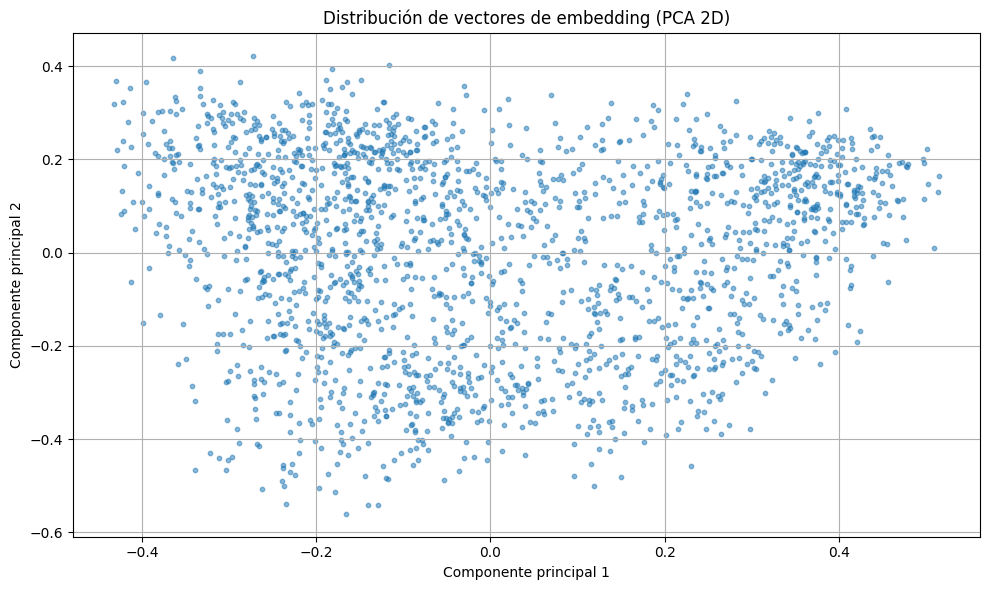

In [ ]:
import pandas as pd
import numpy as np
import ast
from collections import Counter

# Ruta al corpus final
csv_path = "/content/drive/MyDrive/tesis/datasets/NuminaMath-1.5_rag_corpus/NuminaMath-1.5_rag_corpus_final.csv"
df = pd.read_csv(csv_path)

# ─── 1. Análisis de distribución por categorías ────────────────
print("\n📊 Distribución por tipo de problema (problem_type):")
problem_counts = Counter(df.get("problem_type", []))
for cat, count in problem_counts.items():
    print(f"  • {cat or '[vacío]'}: {count}")

print("\n📊 Distribución por tipo de pregunta (question_type):")
question_counts = Counter(df.get("question_type", []))
for cat, count in question_counts.items():
    print(f"  • {cat or '[vacío]'}: {count}")


# Función robusta para convertir strings a vectores float
def parse_embedding_from_numpy_string(s):
    try:
        # Eliminar corchetes y dividir por espacios
        s_clean = re.sub(r'[\[\]]', '', str(s)).strip()
        return [float(num) for num in s_clean.split() if re.match(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", num)]
    except Exception:
        return None

# Procesar solo los vectores válidos
valid_embeddings = df["embedding"].dropna().apply(parse_embedding_from_numpy_string)
valid_embeddings = [vec for vec in valid_embeddings if vec and len(vec) > 0]

# Convertir a array
embedding_matrix = np.array(valid_embeddings)

# ─── Estadísticas ─────────────────────────────────────────────
print(f"\n📈 Estadísticas de los vectores:")
print(f"  • Total embeddings válidos: {len(embedding_matrix)}")
print(f"  • Dimensión del vector: {embedding_matrix.shape[1]}")
print(f"  • Mínimo valor: {embedding_matrix.min():.4f}")
print(f"  • Máximo valor: {embedding_matrix.max():.4f}")
print(f"  • Media por dimensión (primeras 5): {np.mean(embedding_matrix, axis=0)[:5]}")
print(f"  • Desviación estándar (primeras 5): {np.std(embedding_matrix, axis=0)[:5]}")


# Función para convertir una cadena tipo "[0.1 0.2 -0.3 ...]" a lista de floats
def parse_embedding(s):
    try:
        s_clean = re.sub(r'[\[\]]', '', str(s))
        return [float(x) for x in s_clean.split()]
    except:
        return None


# Extraer los embeddings válidos
parsed = df["embedding"].dropna().apply(parse_embedding)
valid_embeddings = [v for v in parsed if v and len(v) > 0]
embedding_matrix = np.array(valid_embeddings)

# Reducir dimensión con PCA para visualización
pca = PCA(n_components=2)
reduced = pca.fit_transform(embedding_matrix)

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], s=10, alpha=0.5)
plt.title("Distribución de vectores de embedding (PCA 2D)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.tight_layout()
plt.show()

#generado